# Mortgage Churn Prediction - Model Training

Dieses Notebook trainiert und evaluiert verschiedene Machine Learning Modelle für Mortgage Churn Prediction.

**Ziel:** Vergleich von Random Forest und Logistic Regression

## Inhaltsverzeichnis
1. Daten laden
2. Feature Selection
3. Train/Test Split
4. Baseline Models trainieren
5. Model Evaluation
6. Model Comparison
7. Best Model speichern

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)

# Project modules
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))
from hypo_churn.models import ChurnPredictor
from hypo_churn.evaluation import evaluate_model, print_evaluation_results

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports erfolgreich")

✓ Imports erfolgreich


## 1. Daten laden

In [2]:
# Pfade
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Daten laden
data_file = DATA_DIR / 'banking_churn_mortgage_adapted.csv'
print(f"Lade Daten von: {data_file}")

df = pd.read_csv(data_file)
print(f"✓ Daten geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")

# Erste Zeilen anzeigen
df.head()

Lade Daten von: /home/manuel/hypo-churn/data/processed/banking_churn_mortgage_adapted.csv
✓ Daten geladen: 10000 Zeilen, 20 Spalten


,RowNumber,CustomerId,Surname,credit_score,Geography,Gender,Age,loan_age_years,outstanding_loan_balance,num_bank_products,has_credit_card,online_banking_active,annual_income,churned,monthly_income,estimated_property_value,ltv_ratio,payment_to_income_ratio,risk_score,balance_per_product
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8445.740000,354721.080,0.000000,0.000000,0.168000,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,9378.548333,393899.030,0.212765,0.037234,0.251000,83807.860000
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9494.297500,398760.495,0.400393,0.070069,0.394229,53220.266667
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,7818.885833,328393.205,0.000000,0.000000,0.109818,0.000000
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,6590.341667,276794.350,0.453444,0.079353,0.159839,125510.820000


In [3]:
# Dataset Info
print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nTarget Distribution:")
print(df['churned'].value_counts())
print(f"\nChurn Rate: {df['churned'].mean():.2%}")

DATASET INFORMATION
Shape: (10000, 20)

Target Distribution:
churned
0    7963
1    2037
Name: count, dtype: int64

Churn Rate: 20.37%


## 2. Feature Selection

In [4]:
# Features für das Modell auswählen
# Entferne nicht-prädiktive Spalten
drop_columns = ['RowNumber', 'CustomerId', 'Surname', 'churned']

# Verfügbare Features
all_features = [col for col in df.columns if col not in drop_columns]

print(f"Verfügbare Features ({len(all_features)}):")
for i, feat in enumerate(all_features, 1):
    print(f"  {i}. {feat}")

# Feature Matrix und Target
X = df[all_features]
y = df['churned']

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Verfügbare Features (16):
  1. credit_score
  2. Geography
  3. Gender
  4. Age
  5. loan_age_years
  6. outstanding_loan_balance
  7. num_bank_products
  8. has_credit_card
  9. online_banking_active
  10. annual_income
  11. monthly_income
  12. estimated_property_value
  13. ltv_ratio
  14. payment_to_income_ratio
  15. risk_score
  16. balance_per_product

Feature Matrix Shape: (10000, 16)
Target Shape: (10000,)


In [5]:
# Kategorische Features encoding
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

if categorical_features:
    print(f"Kategorische Features gefunden: {categorical_features}")
    X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
    print(f"✓ One-Hot Encoding durchgeführt")
    print(f"Neue Feature Matrix Shape: {X_encoded.shape}")
else:
    X_encoded = X.copy()
    print("Keine kategorischen Features gefunden")

# Finale Features
feature_names = X_encoded.columns.tolist()
print(f"\nFinale Feature Count: {len(feature_names)}")

Kategorische Features gefunden: ['Geography', 'Gender']
✓ One-Hot Encoding durchgeführt
Neue Feature Matrix Shape: (10000, 17)

Finale Feature Count: 17


## 3. Train/Test Split

In [6]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train/Test Split:")
print(f"  Training Set: {X_train.shape[0]} Samples ({X_train.shape[0]/len(X_encoded):.1%})")
print(f"  Test Set: {X_test.shape[0]} Samples ({X_test.shape[0]/len(X_encoded):.1%})")
print(f"\nChurn Rate in Training Set: {y_train.mean():.2%}")
print(f"Churn Rate in Test Set: {y_test.mean():.2%}")

Train/Test Split:
  Training Set: 8000 Samples (80.0%)
  Test Set: 2000 Samples (20.0%)

Churn Rate in Training Set: 20.38%
Churn Rate in Test Set: 20.35%


In [7]:
# Feature Scaling (wichtig für Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Zurück zu DataFrames für bessere Handhabung
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

print("✓ Feature Scaling durchgeführt (StandardScaler)")

✓ Feature Scaling durchgeführt (StandardScaler)


## 4. Baseline Models trainieren

In [8]:
# Model 1: Random Forest
print("="*70)
print("Training Random Forest Classifier")
print("="*70)

rf_model = ChurnPredictor(model_type='random_forest')
rf_model.train(X_train, y_train)  # Random Forest braucht kein Scaling

print("✓ Random Forest Training abgeschlossen")

Training Random Forest Classifier
✓ Random Forest Training abgeschlossen


In [9]:
# Model 2: Logistic Regression
print("="*70)
print("Training Logistic Regression Classifier")
print("="*70)

lr_model = ChurnPredictor(model_type='logistic_regression')
lr_model.train(X_train_scaled, y_train)  # Logistic Regression braucht Scaling

print("✓ Logistic Regression Training abgeschlossen")

Training Logistic Regression Classifier
✓ Logistic Regression Training abgeschlossen


## 5. Model Evaluation

In [10]:
# Random Forest Evaluation
print("="*70)
print("RANDOM FOREST - EVALUATION")
print("="*70)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

rf_metrics = evaluate_model(y_test, y_pred_rf, y_proba_rf)
print_evaluation_results(rf_metrics)

RANDOM FOREST - EVALUATION

Model Evaluation Results
Accuracy: 0.8635
Precision: 0.7863
Recall: 0.4521
F1 Score: 0.5741
Roc Auc: 0.8529



In [11]:
# Logistic Regression Evaluation
print("="*70)
print("LOGISTIC REGRESSION - EVALUATION")
print("="*70)

y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)

lr_metrics = evaluate_model(y_test, y_pred_lr, y_proba_lr)
print_evaluation_results(lr_metrics)

LOGISTIC REGRESSION - EVALUATION

Model Evaluation Results
Accuracy: 0.8085
Precision: 0.5952
Recall: 0.1843
F1 Score: 0.2814
Roc Auc: 0.7730



## 6. Model Comparison

MODEL COMPARISON
                     accuracy  precision    recall  f1_score   roc_auc
Random Forest          0.8635   0.786325  0.452088  0.574103  0.852871
Logistic Regression    0.8085   0.595238  0.184275  0.281426  0.773001


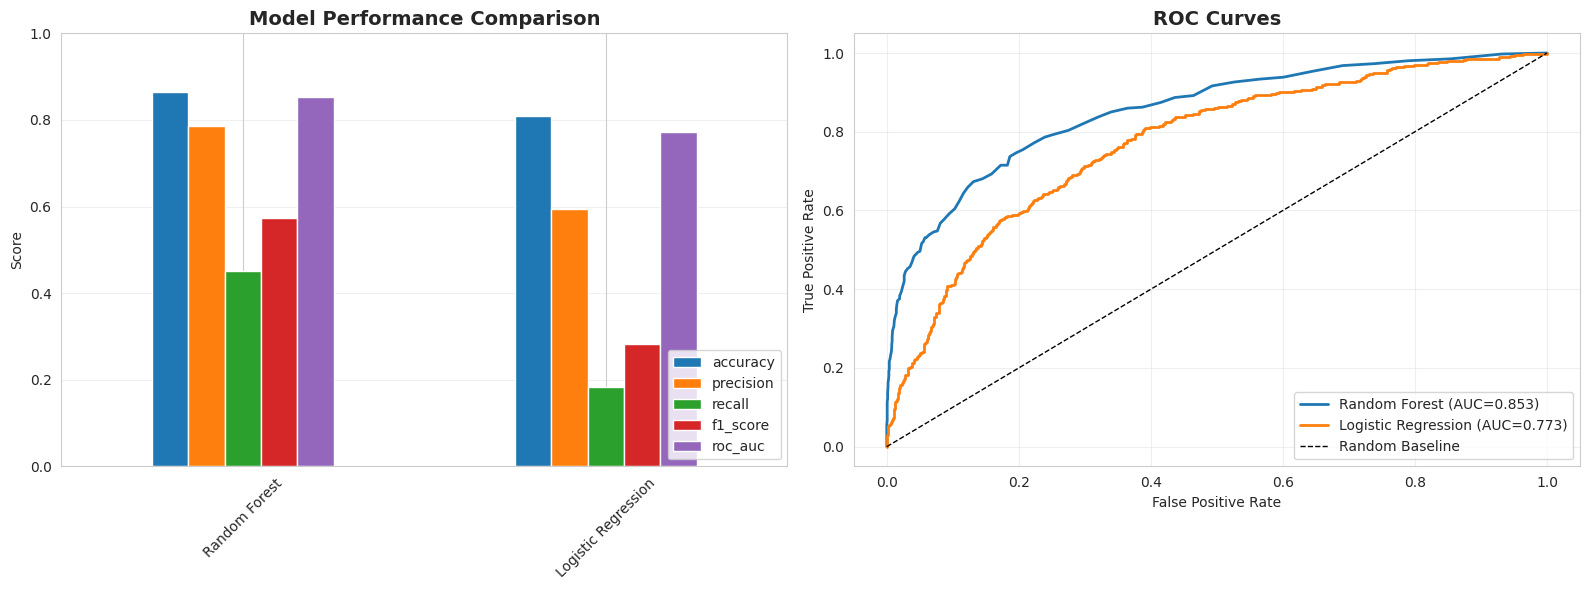

In [12]:
# Metrics Vergleich
comparison_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'Logistic Regression': lr_metrics
}).T

print("="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics Bar Plot
comparison_df.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr[:, 1])

axes[1].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_metrics['roc_auc']:.3f})", linewidth=2)
axes[1].plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={lr_metrics['roc_auc']:.3f})", linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Baseline', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

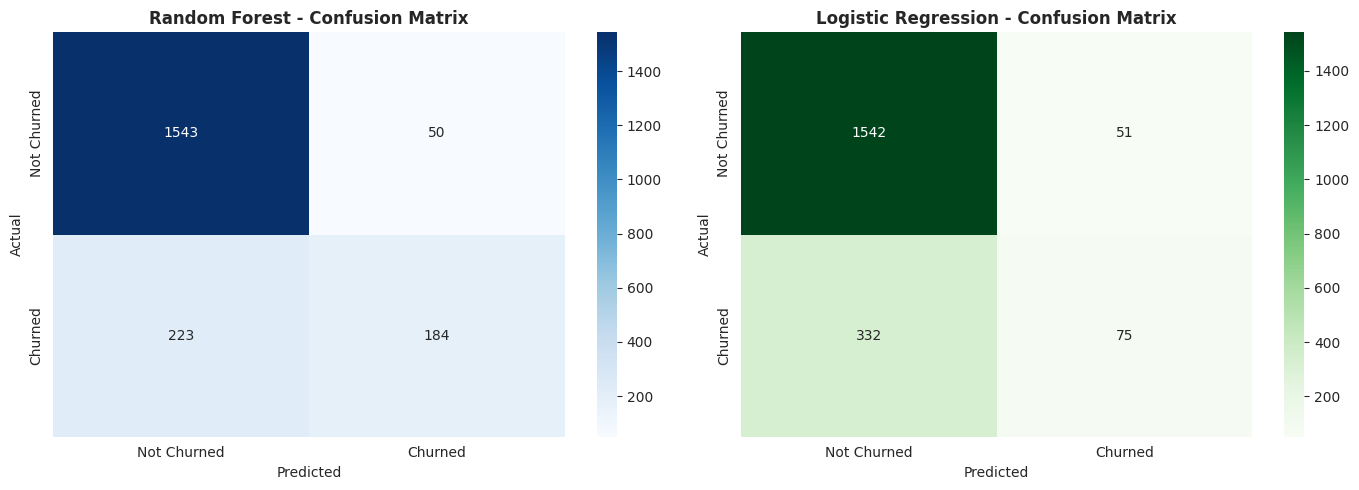

In [13]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest - Confusion Matrix', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Not Churned', 'Churned'])
axes[0].set_yticklabels(['Not Churned', 'Churned'])

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Logistic Regression - Confusion Matrix', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Not Churned', 'Churned'])
axes[1].set_yticklabels(['Not Churned', 'Churned'])

plt.tight_layout()
plt.show()

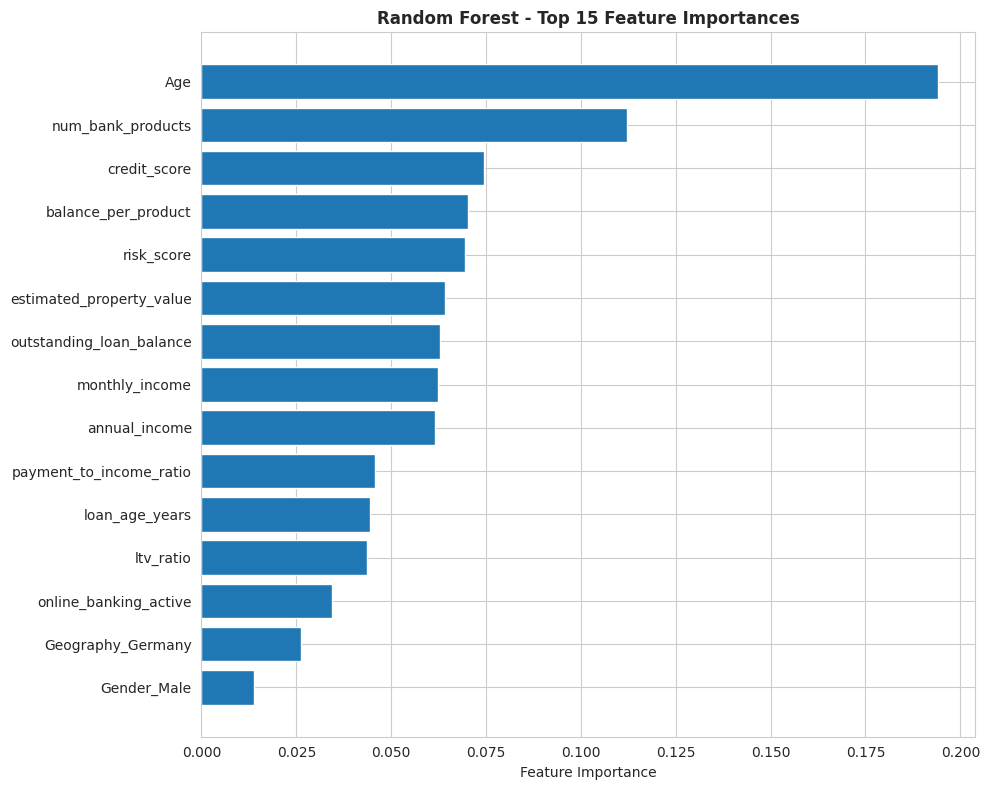


Top 10 Important Features:
                     feature  importance
1                        Age    0.194096
4          num_bank_products    0.112098
0               credit_score    0.074342
13       balance_per_product    0.070371
12                risk_score    0.069396
9   estimated_property_value    0.064304
3   outstanding_loan_balance    0.062753
8             monthly_income    0.062399
7              annual_income    0.061609
11   payment_to_income_ratio    0.045685


In [14]:
# Feature Importance (Random Forest)
if hasattr(rf_model.model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest - Top 15 Feature Importances', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Important Features:")
    print(importance_df.head(10))

## 7. Best Model speichern

In [15]:
# Bestes Modell basierend auf ROC-AUC auswählen
if rf_metrics['roc_auc'] > lr_metrics['roc_auc']:
    best_model = rf_model
    best_model_name = 'random_forest'
    best_metrics = rf_metrics
    best_scaler_needed = False
else:
    best_model = lr_model
    best_model_name = 'logistic_regression'
    best_metrics = lr_metrics
    best_scaler_needed = True

print("="*70)
print("BEST MODEL SELECTION")
print("="*70)
print(f"Best Model: {best_model_name.upper()}")
print(f"ROC-AUC Score: {best_metrics['roc_auc']:.4f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")

BEST MODEL SELECTION
Best Model: RANDOM_FOREST
ROC-AUC Score: 0.8529
Accuracy: 0.8635
F1-Score: 0.5741


In [16]:
# Modell speichern
model_path = MODELS_DIR / f'best_model_{best_model_name}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Model gespeichert: {model_path}")

# Scaler speichern (falls benötigt)
if best_scaler_needed:
    scaler_path = MODELS_DIR / 'scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✓ Scaler gespeichert: {scaler_path}")

# Feature Namen speichern
feature_names_path = MODELS_DIR / 'feature_names.pkl'
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_names, f)
print(f"✓ Feature Names gespeichert: {feature_names_path}")

# Metrics speichern
metrics_path = MODELS_DIR / 'best_model_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(best_metrics, f)
print(f"✓ Metrics gespeichert: {metrics_path}")

✓ Model gespeichert: /home/manuel/hypo-churn/models/best_model_random_forest.pkl
✓ Feature Names gespeichert: /home/manuel/hypo-churn/models/feature_names.pkl
✓ Metrics gespeichert: /home/manuel/hypo-churn/models/best_model_metrics.pkl


## Zusammenfassung

### Ergebnisse:

**Models trainiert:**
- Random Forest Classifier
- Logistic Regression Classifier

**Performance Vergleich:**
- Beide Modelle wurden auf identischen Test-Daten evaluiert
- Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Best Model wurde basierend auf ROC-AUC Score ausgewählt

**Gespeicherte Artifacts:**
- Best Model (pickle)
- Feature Scaler (falls benötigt)
- Feature Names
- Performance Metrics

### Nächste Schritte:
1. **Hyperparameter Tuning:** GridSearch/RandomSearch für bessere Performance
2. **Class Imbalance:** SMOTE oder Class Weights testen
3. **Feature Engineering:** Weitere Features erstellen
4. **Ensemble Methods:** Stacking/Voting Classifier
5. **Model Deployment:** API oder Web-Interface erstellen